In [1]:
# Importing all the required libraries
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division

!pip install chart_studio 
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 71kB 2.1MB/s 


In [0]:
# Load data. This dataset contains all purchases made for an online retail company based in the UK during an eight month period.
tx_data = pd.read_csv("/content/drive/My Drive/Finlytics Hub/Data Science/Customer Analytics/OnlineRetail.csv", encoding = "unicode_escape")

In [3]:
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
tx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Our North Star Metric (single metric that best captures the core value that your product delivers to customers) for this data set will be Monthly Revenue that can be calculated as: Active Customer Count * Order Count * Average Revenue per Order

## Feature Engineering

In [5]:
# Convert InvoiceDate to DateTime format
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])
tx_data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [6]:
# Create a new column in this format YYYYMM based on InvoiceDate
tx_data['InvoiceYearMonth'] = tx_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012


In [7]:
# Create a Revenue Column
tx_data['Revenue'] = tx_data['UnitPrice'] * tx_data['Quantity']
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [8]:
# Create a GroupBy DF that shows monthly total revenue for all customers
tx_revenue = tx_data.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
tx_revenue

,InvoiceYearMonth,Revenue
0,201012,748957.020
1,201101,560000.260
2,201102,498062.650
3,201103,683267.080
4,201104,493207.121
5,201105,723333.510
6,201106,691123.120
7,201107,681300.111
8,201108,682680.510
9,201109,1019687.622


## Data Visualisation

In [9]:
# Visualise Month-on-Month Revenue
plot_data = [
    go.Scatter(
        x=tx_revenue['InvoiceYearMonth'],
        y=tx_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [10]:
# Add a new MonthlyGrowth column in the tx_revenue DF
tx_revenue['MonthlyGrowth'] = tx_revenue['Revenue'].pct_change()
tx_revenue

,InvoiceYearMonth,Revenue,MonthlyGrowth
0,201012,748957.020,NaN
1,201101,560000.260,-0.252293
2,201102,498062.650,-0.110603
3,201103,683267.080,0.371850
4,201104,493207.121,-0.278163
5,201105,723333.510,0.466592
6,201106,691123.120,-0.044530
7,201107,681300.111,-0.014213
8,201108,682680.510,0.002026
9,201109,1019687.622,0.493653


In [11]:
# Plot % Monthly Revenue Growth after excluding Dec 2011 since it's not complete yet (last tx date was 9 Dec 2011)
plot_data = [
    go.Scatter(
        x=tx_revenue.query("InvoiceYearMonth < 201112")['InvoiceYearMonth'],
        y=tx_revenue.query("InvoiceYearMonth < 201112")['MonthlyGrowth'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue Growth Rate'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Not too sure of the reason for the big dive in Apr 2011

## Metrics Calculations and Visualisations

In [12]:
# Check the country-wise distribution of total revenue
tx_data.groupby('Country')['Revenue'].sum().sort_values(ascending=False).astype(int)

Country
United Kingdom          8187806
Netherlands              284661
EIRE                     263276
Germany                  221698
France                   197403
Australia                137077
Switzerland               56385
Spain                     54774
Belgium                   40910
Sweden                    36595
Japan                     35340
Norway                    35163
Portugal                  29367
Finland                   22326
Channel Islands           20086
Denmark                   18768
Italy                     16890
Cyprus                    12946
Austria                   10154
Hong Kong                 10117
Singapore                  9120
Israel                     7907
Poland                     7213
Unspecified                4749
Greece                     4710
Iceland                    4309
Canada                     3666
Malta                      2505
United Arab Emirates       1902
USA                        1730
Lebanon                    1693


We will evaluate UK from this step onwards given its large size

In [13]:
# Extract all UK transactions to a new DF
tx_uk = tx_data[tx_data["Country"] == "United Kingdom"].reset_index(drop = True)
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [14]:
tx_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495478 entries, 0 to 495477
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         495478 non-null  object        
 1   StockCode         495478 non-null  object        
 2   Description       494024 non-null  object        
 3   Quantity          495478 non-null  int64         
 4   InvoiceDate       495478 non-null  datetime64[ns]
 5   UnitPrice         495478 non-null  float64       
 6   CustomerID        361878 non-null  float64       
 7   Country           495478 non-null  object        
 8   InvoiceYearMonth  495478 non-null  int64         
 9   Revenue           495478 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 37.8+ MB


In [15]:
# Create a new GroupBy DF for Monthly Active UK customers
tx_monthly_active = tx_uk.groupby('InvoiceYearMonth')['CustomerID'].nunique().reset_index()
tx_monthly_active.columns = ["Invoice_Year_Month", "Unique_Customers"]
tx_monthly_active

,Invoice_Year_Month,Unique_Customers
0,201012,871
1,201101,684
2,201102,714
3,201103,923
4,201104,817
5,201105,985
6,201106,943
7,201107,899
8,201108,867
9,201109,1177


In [18]:
# Create a bar plot for monthly active customers
plot_data = [
    go.Bar(
        x=tx_monthly_active['Invoice_Year_Month'],
        y=tx_monthly_active['Unique_Customers'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Active Customers'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [19]:
# Redo the above for monthly total quantites ordered in UK
tx_monthly_sales = tx_uk.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()
tx_monthly_sales.columns = ["Invoice_Year_Month", "Total_Quantity"]
tx_monthly_sales

,Invoice_Year_Month,Total_Quantity
0,201012,298101
1,201101,237381
2,201102,225641
3,201103,279843
4,201104,257666
5,201105,306452
6,201106,258522
7,201107,324129
8,201108,319804
9,201109,458490


In [20]:
# Plot the above data
plot_data = [
    go.Bar(
        x=tx_monthly_sales['Invoice_Year_Month'],
        y=tx_monthly_sales['Total_Quantity'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Total Quantities Ordered'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [21]:
# Let's check the average revenue per order on a monthly basis
tx_monthly_order_avg = tx_uk.groupby('InvoiceYearMonth')['Revenue'].mean().reset_index()
tx_monthly_order_avg.columns = ["Invoice_Year_Month", "Avg_Order_Size"]
tx_monthly_order_avg

,Invoice_Year_Month,Avg_Order_Size
0,201012,16.865860
1,201101,13.614680
2,201102,16.093027
3,201103,16.716166
4,201104,15.773380
5,201105,17.713823
6,201106,16.714748
7,201107,15.723497
8,201108,17.315899
9,201109,18.931723


In [22]:
# Plot the above data
plot_data = [
    go.Bar(
        x=tx_monthly_order_avg['Invoice_Year_Month'],
        y=tx_monthly_order_avg['Avg_Order_Size'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Average Order Size (Revenue)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### New Customer Ratio

We will now analyze revenue for both new and existing customers. For each unique customer we will determine the first month during which it made a purchase within the data set. Then for each transaction, if the transaction month was later than the first transaction month of that specific customer he/she will be classified as an Existing Customer, otherwise he/she will be classified as a New Customer

In [23]:
# Create a new DF that that stores the first (minimum) transaction month for each unique CustomerID
tx_min_purchase = tx_uk.groupby('CustomerID')["InvoiceDate"].min().reset_index()
tx_min_purchase.columns = ['CustomerID','MinPurchaseDate']
tx_min_purchase['MinPurchaseYearMonth'] = tx_min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)
tx_min_purchase.head()

,CustomerID,MinPurchaseDate,MinPurchaseYearMonth
0,12346.0,2011-01-18 10:01:00,201101
1,12747.0,2010-12-05 15:38:00,201012
2,12748.0,2010-12-01 12:48:00,201012
3,12749.0,2011-05-10 15:25:00,201105
4,12820.0,2011-01-17 12:34:00,201101


In [24]:
# Merge the above DF with tx_uk so that we have the earliest tx month of the customer in our main tx_uk DF
tx_uk = pd.merge(tx_uk, tx_min_purchase, on='CustomerID')
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue,MinPurchaseDate,MinPurchaseYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30,2010-12-01 08:26:00,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00,2010-12-01 08:26:00,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012


In [25]:
# Create a new UserType column to identify whether the tx was by a new or an existing customer
tx_uk['UserType'] = 'New'
# For each row where invoice is later than the earliest tx month of customer, update UserType column to Existing
tx_uk.loc[tx_uk['InvoiceYearMonth']>tx_uk['MinPurchaseYearMonth'], 'UserType'] = 'Existing'
tx_uk["UserType"].value_counts()

Existing    256114
New         105764
Name: UserType, dtype: int64

In [26]:
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue,MinPurchaseDate,MinPurchaseYearMonth,UserType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30,2010-12-01 08:26:00,201012,New
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00,2010-12-01 08:26:00,201012,New
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New


In [27]:
# Create a new DF that groups tx_uk by both invoice month and user classification with values of total monthly revenue
tx_user_type_revenue = tx_uk.groupby(['InvoiceYearMonth','UserType'])['Revenue'].sum().reset_index()
tx_user_type_revenue

,InvoiceYearMonth,UserType,Revenue
0,201012,New,483799.740
1,201101,Existing,195275.510
2,201101,New,156705.770
3,201102,Existing,220994.630
4,201102,New,127859.000
5,201103,Existing,296350.030
6,201103,New,160567.840
7,201104,Existing,268226.660
8,201104,New,108517.751
9,201105,Existing,434725.860


In [28]:
# We will drop the first row since there are no Existing users therein (as per our definition) 
# and the last 2 rows since we know that the data for December is not complete
tx_user_type_revenue.drop(index = [0, 23, 24], inplace = True)
tx_user_type_revenue

,InvoiceYearMonth,UserType,Revenue
1,201101,Existing,195275.510
2,201101,New,156705.770
3,201102,Existing,220994.630
4,201102,New,127859.000
5,201103,Existing,296350.030
6,201103,New,160567.840
7,201104,Existing,268226.660
8,201104,New,108517.751
9,201105,Existing,434725.860
10,201105,New,90847.490


In [29]:
# Now let's plot the above data
plot_data = [
    go.Scatter(
        x=tx_user_type_revenue.query("UserType == 'Existing'")['InvoiceYearMonth'],
        y=tx_user_type_revenue.query("UserType == 'Existing'")['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x=tx_user_type_revenue.query("UserType == 'New'")['InvoiceYearMonth'],
        y=tx_user_type_revenue.query("UserType == 'New'")['Revenue'],
        name = 'New'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Revenue between New vs Existing'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Existing customers are showing a positive trend and tell us that our customer base is growing but new customers have a slight negative trend.

In [30]:
# Calculate New Customer Ratio (unique new customers divided by unique existing customers)
tx_user_ratio = tx_uk[tx_uk["UserType"] == "New"].groupby(['InvoiceYearMonth'])['CustomerID'].nunique() / tx_uk[tx_uk["UserType"] == "Existing"].groupby(['InvoiceYearMonth'])['CustomerID'].nunique() 
tx_user_ratio = tx_user_ratio.reset_index()
tx_user_ratio = tx_user_ratio.dropna()
tx_user_ratio

,InvoiceYearMonth,CustomerID
1,201101,1.124224
2,201102,0.904000
3,201103,0.792233
4,201104,0.510166
5,201105,0.343793
6,201106,0.281250
7,201107,0.236589
8,201108,0.192572
9,201109,0.304878
10,201110,0.328852


In [31]:
# Let's plot the above new customer ratios to see the trend
plot_data = [
    go.Bar(
        x=tx_user_ratio.query("InvoiceYearMonth>201101 and InvoiceYearMonth<201112")['InvoiceYearMonth'],
        y=tx_user_ratio.query("InvoiceYearMonth>201101 and InvoiceYearMonth<201112")['CustomerID'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New Customer Ratio'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

New Customer Ratio has declined as expected (we assumed in Feb, all customers were New) and running around 20%.

### Monthly Retention Rates

Retention rate should be monitored very closely because it indicates how sticky is our service and how well our product fits the market. For making Monthly Retention Rate visualized, we need to calculate how many customers were retained from the previous month.

Note that we will be calculating it on a monthly basis, so if a customer return to us after a month's gap, he would not be considered as a retained customer for the month being evaluated

Monthly Retention Rate = Retained Customers From Prev. Month/Active Total Customers

In [32]:
# First, we create a dataframe that shows total monthly revenue for each customer
tx_user_purchase = tx_uk.groupby(['CustomerID','InvoiceYearMonth'])['Revenue'].sum().astype(int).reset_index()
tx_user_purchase.head()

,CustomerID,InvoiceYearMonth,Revenue
0,12346.0,201101,0
1,12747.0,201012,706
2,12747.0,201101,303
3,12747.0,201103,310
4,12747.0,201105,771


In [33]:
# Using the crosstab function we determine the months in which each customer was active 
tx_retention = pd.crosstab(tx_user_purchase['CustomerID'], tx_user_purchase['InvoiceYearMonth']).reset_index()
tx_retention.head()

InvoiceYearMonth,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
0,12346.0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,12747.0,1,1,0,1,0,1,1,0,1,0,1,1,1
2,12748.0,1,1,1,1,1,1,1,1,1,1,1,1,1
3,12749.0,0,0,0,0,0,1,0,0,1,0,0,1,1
4,12820.0,0,1,0,0,0,0,0,0,0,1,1,0,1


In [34]:
months = tx_retention.columns[2:]
months

Index([201101, 201102, 201103, 201104, 201105, 201106, 201107, 201108, 201109,
       201110, 201111, 201112],
      dtype='object', name='InvoiceYearMonth')

In [35]:
# With the help of a simple for loop, for each month we calculate Retained Customer Count from previous month and Total Customer Count.

retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = tx_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = tx_retention[(tx_retention[selected_month]>0) & (tx_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)

# Convert retention_array to a DF and replace tx_retention with it
tx_retention = pd.DataFrame(retention_array)
tx_retention

,InvoiceYearMonth,TotalUserCount,RetainedUserCount
0,201102,714,263
1,201103,923,305
2,201104,817,310
3,201105,985,369
4,201106,943,417
5,201107,899,379
6,201108,867,391
7,201109,1177,417
8,201110,1285,502
9,201111,1548,616


In [36]:
# Calculate Retention Rate
tx_retention['RetentionRate'] = tx_retention['RetainedUserCount']/tx_retention['TotalUserCount']
tx_retention

,InvoiceYearMonth,TotalUserCount,RetainedUserCount,RetentionRate
0,201102,714,263,0.368347
1,201103,923,305,0.330444
2,201104,817,310,0.379437
3,201105,985,369,0.374619
4,201106,943,417,0.442206
5,201107,899,379,0.421580
6,201108,867,391,0.450980
7,201109,1177,417,0.354291
8,201110,1285,502,0.390661
9,201111,1548,616,0.397933


In [37]:
# Plot the above date
plot_data = [
    go.Scatter(
        x=tx_retention.query("InvoiceYearMonth<201112")['InvoiceYearMonth'],
        y=tx_retention.query("InvoiceYearMonth<201112")['RetentionRate'],
        name="organic"
    )
    
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Customer Retention Rate'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Monthly Retention Rate significantly jumped between June and August and went back to previous levels afterwards.

## Cohort Retention Analysis

In [45]:
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue,MinPurchaseDate,MinPurchaseYearMonth,UserType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30,2010-12-01 08:26:00,201012,New
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00,2010-12-01 08:26:00,201012,New
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New


In [0]:
# First, let’s calculate the date difference between the first transaction (MinPurchaseDate) and the next activity (InvoiceDate) for each trnsaction
# We will create a function and apply it to our dataframe.
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

invoice_year, invoice_month, _ = get_date_int(tx_uk, 'InvoiceDate')
cohort_year, cohort_month, _ = get_date_int(tx_uk, 'MinPurchaseDate')

In [0]:
# Next let’s get the value of the year and month difference between the transaction month and Cohort Month.
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

In [49]:
# We will now construct our cohort index based on the number of months since the first transaction of that customer for each transaction.
# This ensures that we will also consider returning customers in our retention calculation.
# Cohort Index is assigned as follows: 1 for the first month in our dataset (Dec10), 2nd for the second month (Jan11) in our dataset and so on.
tx_uk['CohortIndex'] = years_diff * 12 + months_diff + 1
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue,MinPurchaseDate,MinPurchaseYearMonth,UserType,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30,2010-12-01 08:26:00,201012,New,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00,2010-12-01 08:26:00,201012,New,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New,1


In [60]:
# Group the data by the first purchase month and the Cohort Index
grouping_count = tx_uk.groupby(['MinPurchaseYearMonth', 'CohortIndex'])
# Get the number of CustomerID for each combination of MinPurchaseYearMonth & CohortIndex
cohort_data = grouping_count['CustomerID'].nunique().reset_index()
# Create a pivot table for a nice tabular representation
cohort_counts = cohort_data.pivot(index='MinPurchaseYearMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
MinPurchaseYearMonth,,,,,,,,,,,,,
201012,871.0,322.0,291.0,329.0,308.0,345.0,327.0,304.0,306.0,346.0,320.0,429.0,238.0
201101,362.0,84.0,101.0,89.0,124.0,106.0,95.0,94.0,114.0,127.0,131.0,54.0,NaN
201102,339.0,85.0,65.0,95.0,96.0,86.0,88.0,96.0,94.0,106.0,33.0,NaN,NaN
201103,408.0,79.0,107.0,88.0,95.0,70.0,107.0,97.0,119.0,38.0,NaN,NaN,NaN
201104,276.0,62.0,61.0,60.0,57.0,64.0,64.0,73.0,23.0,NaN,NaN,NaN,NaN
201105,252.0,58.0,43.0,43.0,54.0,60.0,67.0,25.0,NaN,NaN,NaN,NaN,NaN
201106,207.0,44.0,34.0,51.0,53.0,67.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
201107,172.0,35.0,33.0,40.0,48.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,140.0,37.0,32.0,36.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# Calculate Retention Rate
cohort_sizes = cohort_counts.iloc[:,0] # Get the first column in pivot under 1 which is count of unique customers in each month
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
MinPurchaseYearMonth,,,,,,,,,,,,,
201012,1.0,0.369690,0.334099,0.377727,0.353617,0.396096,0.375431,0.349024,0.351320,0.397245,0.367394,0.492537,0.273249
201101,1.0,0.232044,0.279006,0.245856,0.342541,0.292818,0.262431,0.259669,0.314917,0.350829,0.361878,0.149171,NaN
201102,1.0,0.250737,0.191740,0.280236,0.283186,0.253687,0.259587,0.283186,0.277286,0.312684,0.097345,NaN,NaN
201103,1.0,0.193627,0.262255,0.215686,0.232843,0.171569,0.262255,0.237745,0.291667,0.093137,NaN,NaN,NaN
201104,1.0,0.224638,0.221014,0.217391,0.206522,0.231884,0.231884,0.264493,0.083333,NaN,NaN,NaN,NaN
201105,1.0,0.230159,0.170635,0.170635,0.214286,0.238095,0.265873,0.099206,NaN,NaN,NaN,NaN,NaN
201106,1.0,0.212560,0.164251,0.246377,0.256039,0.323671,0.096618,NaN,NaN,NaN,NaN,NaN,NaN
201107,1.0,0.203488,0.191860,0.232558,0.279070,0.110465,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,1.0,0.264286,0.228571,0.257143,0.135714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


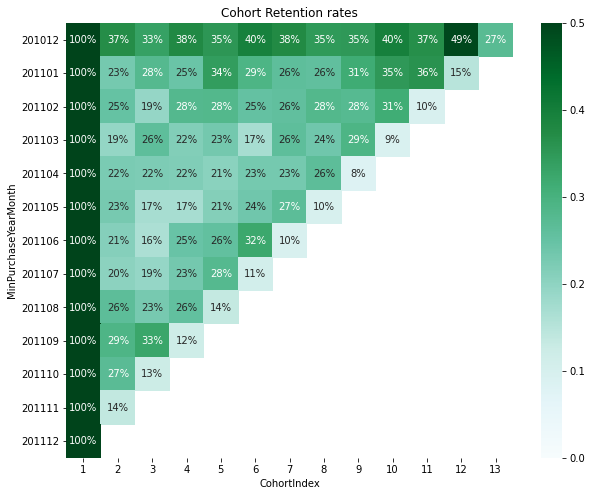

In [86]:
# Plot a heatmap of the above data
plt.figure(figsize=(10, 8))
plt.title('Cohort Retention rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()

Unsurprisingly, we can see from the above chart that fewer users tend to purchase as time goes on.

However, we can also see that the 201012 cohort is the strongest, which enables us to ask targeted questions about this cohort compared to others -- what other attributes (besides first purchase month) do these users share which might be causing them to stick around? How were the majority of these users acquired? Was there a specific marketing campaign that brought them in? Did they take advantage of a promotion at sign-up? The answers to these questions would inform future marketing and product efforts.

Notice in our Dec 2010 cohort, there is a spike in the our retention rate (49%) in Dec 2011 (12th Cohort Index) This could potentially indicate the seasonal shopping crowd.

## Cohort Average Order Size Analysis

In [92]:
# Redo the same as above on Revenue column
grouping_price = tx_uk.groupby(['MinPurchaseYearMonth', 'CohortIndex'])
cohort_data_revenue = grouping_price['Revenue'].mean().reset_index()
average_revenue = cohort_data_revenue.pivot(index='MinPurchaseYearMonth',
                                     columns='CohortIndex',
                                     values='Revenue')
average_revenue

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
MinPurchaseYearMonth,,,,,,,,,,,,,
201012,19.717955,20.458409,22.746153,22.056325,19.164291,23.062754,24.152602,21.920586,23.634455,29.193301,27.730112,20.379726,23.424848
201101,17.046206,17.773224,14.879441,16.507275,17.805569,18.333732,23.882265,17.118820,17.523151,16.135274,17.080208,17.807890,NaN
201102,16.103149,16.948838,17.237173,18.522425,15.916667,14.236860,20.690129,20.911559,16.842840,20.339577,22.261679,NaN,NaN
201103,16.109947,17.803490,21.474936,16.563805,18.680265,17.492022,20.209565,16.901364,15.321174,11.312006,NaN,NaN,NaN
201104,16.015016,19.507001,18.568908,18.362583,18.312962,13.262936,14.446640,14.692010,11.040041,NaN,NaN,NaN,NaN
201105,17.141036,15.368866,20.763521,19.465281,17.848668,13.456066,15.893055,11.825245,NaN,NaN,NaN,NaN,NaN
201106,13.792340,13.281673,18.843574,15.785232,12.936181,13.013474,12.488282,NaN,NaN,NaN,NaN,NaN,NaN
201107,12.712007,22.180074,9.863512,12.266326,8.949423,9.148234,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,14.698594,11.765999,11.034870,14.071749,15.629248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


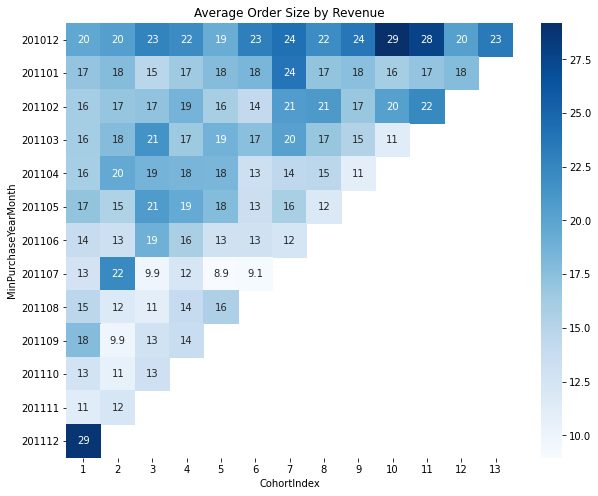

In [93]:
plt.figure(figsize=(10, 8))
plt.title('Average Order Size by Revenue')
sns.heatmap(data = average_revenue, annot=True, cmap='Blues')
plt.show()

Again, we can see that our first cohort remains generally the strongest one!

## Conclusions

* Total monthly revenues were relatively stable up to Aug 2011 before increasing substantially during the 3 months to Nov 2011
* Higher revenues during the 3 months to Nov 2011 could be attributed to:
    - higher active customers during these 3 months
    - higher quantities ordered during these 3 months
* Value of purchases made by existing customers showed an improving trend over the period analysed while new customers had a marginal decline
* New customer ratio (new as a proportion of existing customers) showed a decreasing trend - tying up with our last point
* Monthly Retention rate (based on active customers) remained elevated during June, July and August 
* Cohort retention analysis does not present a very rosy picture - with a substantial decline in returning clients in our latest cohort.